In [1]:
%matplotlib inline

import json
import os
import glob
import boto3

import numpy as np
import matplotlib.pylab as plt

## boto3 client 

In [2]:
client = boto3.client('s3',
                     aws_access_key_id = os.getenv('aws_access_key'),
                     aws_secret_access_key = os.getenv('aws_secret_key'),
                     )

In [4]:
bucket_list = client.list_buckets()

In [5]:
bucket_name = 'summit-demo'

In [15]:
object_list = client.list_objects_v2(Bucket = bucket_name)['Contents']

In [21]:
len(object_list) #TODO: need paginator to get > 1000 objects

1000

In [39]:
paginator = client.get_paginator('list_objects_v2')
pages = paginator.paginate(Bucket=bucket_name, Prefix='ai-sensor/')

key_list = []
for p in pages:
    for o in p['Contents']:
        key_list.append(o['Key'])

In [40]:
len(key_list)

17470

In [41]:
key_list[0]

'ai-sensor/2022-02-24T17:50:02.840805.json'

In [42]:
data_list = []
for k in key_list:
    data = client.get_object(Bucket = bucket_name, Key = k)['Body'].readlines()
    data_list.append(data)

## Plotting

In [50]:
data = [json.loads(d[0].decode('utf-8')) for d in data_list]

In [87]:
json.dump(data, open('data.json', 'w'))

In [52]:
uniq_keys = np.unique([list(d['features'].keys())[0] for d in data])

In [53]:
uniq_keys

array(['led_1', 'led_2', 'led_3', 'led_4', 'light', 'temperature'],
      dtype='<U11')

In [80]:
def get_data(data, colname):
    if colname == 'temperature' or colname == 'light':
        field = 'value'
    else:
        field = 'state'
    
    return [d['features'][colname][field] for d in data if list(d['features'].keys())[0]==colname]

array([1024])

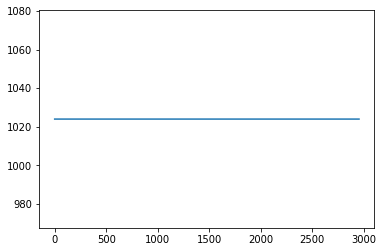

In [81]:
light_data = get_data(data, 'light')
plt.plot(light_data)
np.unique(light_data)

array([23.4, 23.5, 23.6, 23.7, 23.8, 23.9, 24. , 24.3, 24.4, 24.7, 24.9,
       25. , 25.2, 25.5, 25.8, 25.9, 26.1, 26.3, 26.4, 26.5, 26.6, 26.7,
       26.8, 26.9, 27. , 27.1, 27.2, 27.3, 28.3, 29.3, 30.1, 30.2])

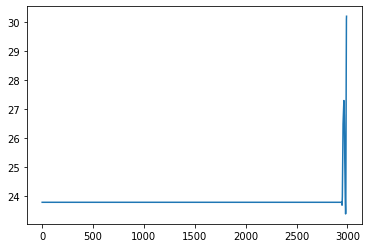

In [82]:
temp_data = get_data(data, 'temperature')

plt.plot(temp_data)
np.unique(temp_data)

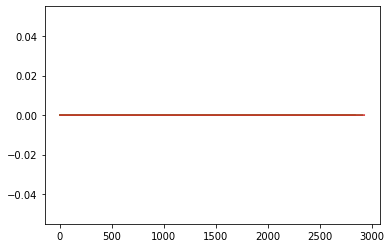

In [83]:
plt.plot(get_data(data, 'led_1'))
plt.plot(get_data(data, 'led_2'))
plt.plot(get_data(data, 'led_3'))
plt.plot(get_data(data, 'led_4'))